In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from keras.utils.np_utils import to_categorical
from keras.models import load_model
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
import tensorflow as tf



from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
# from gensim.models import Word2Vec
# from gensim.models import KeyedVectors
import pickle

import os

from collections import Counter
from scipy.sparse import hstack

from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/IRE_Major_Project/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data = pd.read_csv(root_path+'preprocessed.csv')

In [4]:

data.head()

,id,tweet,new_tweet,user_mentions,n_hash_tags,n_urls,n_emojis,subtask_a,subtask_b,subtask_c,original_tweet_length,new_tweet_length
0,86426,@USER She should ask a few native Americans wh...,she ask native americans their take be,1,0,0,0,OFF,UNT,NaN,14,7
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home you drink maga trump2020,3,2,1,1,OFF,TIN,IND,11,6
2,16820,Amazon is investigating Chinese employees who ...,amazon investigate chinese employees sell inte...,0,5,1,0,NOT,NaN,NaN,27,19
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone should vetaken piece shit volcano,1,0,0,1,OFF,UNT,NaN,11,6
4,43605,@USER @USER Obama wanted liberals &amp; illega...,obama want liberals amp illegals move red state,2,0,0,0,NOT,NaN,NaN,12,8


Dropping subtask a and c columns

In [5]:
data = data[(data['subtask_b'] == 'TIN') | (data['subtask_b'] == 'UNT')]
data.drop(columns  = ['subtask_a' , 'subtask_c'] , inplace  = True)
data.head()

,id,tweet,new_tweet,user_mentions,n_hash_tags,n_urls,n_emojis,subtask_b,original_tweet_length,new_tweet_length
0,86426,@USER She should ask a few native Americans wh...,she ask native americans their take be,1,0,0,0,UNT,14,7
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home you drink maga trump2020,3,2,1,1,TIN,11,6
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone should vetaken piece shit volcano,1,0,0,1,UNT,11,6
5,97670,@USER Liberals are all Kookoo !!!,liberals kookoo,1,0,0,0,TIN,6,2
6,77444,@USER @USER Oh noes! Tough shit.,oh noes tough shit,2,0,0,0,UNT,6,4


# Splitting Data: Train and Test


In [6]:
Y = data['subtask_b']
X = data.drop(['subtask_b','id'],axis=1)
print("Shape of X: ",X.shape)
print("Shape of Y: ",Y.shape)

Shape of X:  (4400, 8)
Shape of Y:  (4400,)


In [7]:
data['subtask_b'].value_counts()

TIN    3876
UNT     524
Name: subtask_b, dtype: int64

In [8]:
#separating data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.30,stratify=Y, random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ",Y_train.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of Y_test: ",Y_test.shape)

Shape of X_train:  (3080, 8)
Shape of Y_train:  (3080,)
Shape of X_test:  (1320, 8)
Shape of Y_test:  (1320,)


#### Change the mapping of the label column to binary


In [0]:
Y_train = Y_train.map(dict(TIN=0, UNT=1))
Y_test = Y_test.map(dict(TIN=0, UNT=1))

In [0]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(X_train.isnull())
#  X_train[X_train.isna().any(axis=1)]

# Convolution Model

In [0]:
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Dropout, Flatten, Lambda, Embedding
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.initializers import RandomNormal
from keras.engine import Layer, InputSpec
from keras import backend as K

## Evaluation Metrics

In [0]:
def recall_m(y_true, y_pred):  
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f_m(y_true, y_pred):
    tmp = precision_recall_fscore_support(y_true , y_pred)
    return tmp[2][1]

# def focal_loss(y_true, y_pred):
#     gamma = 2.0 
#     alpha = 0.25
#     pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#     pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
#     return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

## Model Create

In [0]:
def create_model(filter_kernels, dense_outputs, maxlen, vocab_size, nb_filter, cat_output ):
    initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)

    # Define what the input shape looks like
    inputs = Input(shape=(maxlen,), dtype='int64')

    # Option one:
    # Uncomment following code to use a lambda layer to create a onehot encoding of a sequence of characters on the fly.
    # Holding one-hot encodings in memory is very inefficient.
    # The output_shape of embedded layer will be: batch x maxlen x vocab_size
    #
    import tensorflow as tf

    def one_hot(x):
        return tf.one_hot(x, vocab_size, on_value=1.0, off_value=0.0, axis=-1, dtype=tf.float32)

    def one_hot_outshape(in_shape):
        return in_shape[0], in_shape[1], vocab_size

    embedded = Lambda(one_hot, output_shape=one_hot_outshape)(inputs)

    # Option two:
    # Or, simply use Embedding layer as following instead of use lambda to create one-hot layer
    # Think of it as a one-hot embedding and a linear layer mashed into a single layer.
    # See discussion here: https://github.com/keras-team/keras/issues/4838
    # Note this will introduce one extra layer of weights (of size vocab_size x vocab_size = 69*69 = 4761)
    # embedded = Embedding(input_dim=vocab_size, output_dim=vocab_size)(inputs)

    # All the convolutional layers...
    conv = Convolution1D(filters=nb_filter, kernel_size=filter_kernels[0], kernel_initializer=initializer,
                         padding='valid', activation='relu',
                         input_shape=(maxlen, vocab_size), name='Conv1')(embedded)
    conv = MaxPooling1D(pool_size=3, name='MaxPool1')(conv)

    conv1 = Convolution1D(filters=nb_filter, kernel_size=filter_kernels[1], kernel_initializer=initializer,
                          padding='valid', activation='relu', name='Conv2')(conv)
    conv1 = MaxPooling1D(pool_size=3, name='MaxPool2')(conv1)

    conv2 = Convolution1D(filters=nb_filter, kernel_size=filter_kernels[2], kernel_initializer=initializer,
                          padding='valid', activation='relu', name='Conv3')(conv1)

    conv3 = Convolution1D(filters=nb_filter, kernel_size=filter_kernels[3], kernel_initializer=initializer,
                          padding='valid', activation='relu', name='Conv4')(conv2)

    conv4 = Convolution1D(filters=nb_filter, kernel_size=filter_kernels[4], kernel_initializer=initializer,
                          padding='valid', activation='relu', name='Conv5')(conv3)

    conv5 = Convolution1D(filters=nb_filter, kernel_size=filter_kernels[5], kernel_initializer=initializer,
                          padding='valid', activation='relu',  name='Conv6')(conv4)
    conv5 = MaxPooling1D(pool_size=3,  name='MaxPool3')(conv5)
    k = 40
    # K-max pooling
    def kmax_outshape(in_shape):
        return (in_shape[0], in_shape[2]*k)
    def KMaxPooling(inputs):        
        # swap last two dimensions since top_k will be applied along the last dimension
        shifted_input = tf.transpose(inputs, [0, 2, 1])
        # extract top_k, returns two tensors [values, indices]
        top_k = tf.nn.top_k(shifted_input, k=k, sorted=True, name='TopK')[0]
        return top_k

    # conv5 = Lambda(KMaxPooling, output_shape=kmax_outshape)(conv5)
    conv5 = Flatten()(conv5)

    # Two dense layers with dropout of .5
    z = Dropout(0.5)(Dense(dense_outputs, activation='relu')(conv5))
    z = Dropout(0.5)(Dense(dense_outputs, activation='relu')(z))

    # Output dense layer with softmax activation
    pred = Dense(cat_output, activation='softmax', name='output')(z)

    model = Model(inputs=inputs, outputs=pred)
    print(model.summary())
    sgd = SGD(lr=0.01, momentum=0.9)
    adam = Adam(lr=0.001)  # Feel free to use SGD above. I found Adam with lr=0.001 is faster than SGD with lr=0.01
    # model.compile(loss='categorical_crossentropy' ,optimizer=adam, metrics=['accuracy', f1_m ,precision_m, recall_m])
    # model.compile(loss= [focal_loss] ,optimizer=adam, metrics=['accuracy',  f1_m ,precision_m, recall_m])
    model.compile(loss=focal_loss(alpha=1),optimizer='nadam',metrics=['accuracy'])
    return model

## Making Data Model Ready: Encoding Tweets

### Quantization  

In [0]:
def encode_data(x, maxlen, vocab):
    # Iterate over the loaded data and create a matrix of size (len(x), maxlen)
    # Each character is encoded into a one-hot array later at the lambda layer.
    # Chars not in the vocab are encoded as -1, into an all zero vector.
    
    input_data = np.zeros((len(x), maxlen), dtype=np.int)
    for dix, sent in enumerate(x):
        counter = 0
        for c in sent:
            if counter >= maxlen:
                pass
            else:
                ix = vocab.get(c, -1)  # get index from vocab dictionary, if not in vocab, return -1
                input_data[dix, counter] = ix
                counter += 1
    return input_data


def create_vocab_set():
    # This alphabet is 69 chars vs. 70 reported in the paper since they include two
    # '-' characters. See https://github.com/zhangxiangxiao/Crepe#issues.

    alphabet = set(list(string.ascii_lowercase) + list(string.digits) +
                   list(string.punctuation) + ['\n'])
    vocab_size = len(alphabet)
    vocab = {}
    reverse_vocab = {}
    for ix, t in enumerate(alphabet):
        vocab[t] = ix
        reverse_vocab[ix] = t

    return vocab, reverse_vocab, vocab_size, alphabet

In [0]:
vocab, reverse_vocab, vocab_size, alphabet = create_vocab_set()

# Maximum encoding length. Longer gets chopped. Shorter gets padded.
max_encode_len = 1014

## feature set

In [16]:
f1 = encode_data(X_train['new_tweet'], max_encode_len, vocab)
f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
f5 = X_train['n_emojis'].values.reshape(-1,1)
f6 = X_train['new_tweet_length'].values.reshape(-1,1)
f7 = X_train['original_tweet_length'].values.reshape(-1,1)

X_train_bow = np.concatenate((f1 , f2 , f3 , f4 , f5 , f6 , f7 ) , axis = 1)
print(X_train_bow.shape)

(3080, 1020)


In [17]:
f1 = encode_data(X_test['new_tweet'], max_encode_len, vocab)
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)
f6 = X_test['new_tweet_length'].values.reshape(-1,1)
f7 = X_test['original_tweet_length'].values.reshape(-1,1)


X_test_bow = np.concatenate((f1 , f2 , f3 , f4 , f5 , f6 , f7 ) , axis = 1)
print(X_test_bow.shape)

(1320, 1020)


In [18]:
Y_train_cat  = to_categorical(Y_train) 
Y_test_cat = to_categorical(Y_test)

class_weight = {1:  1 - Y_train.sum()/Y_train.shape[0] , 0 : Y_train.sum()/Y_train.shape[0] }
print("Class_weights : " ,  class_weight)

print(X_train_bow.shape , Y_train.shape , Y_train_cat.shape)
print(X_test_bow.shape , Y_test.shape ,  Y_test_cat.shape)

Class_weights :  {1: 0.8808441558441559, 0: 0.11915584415584415}
(3080, 1020) (3080,) (3080, 2)
(1320, 1020) (1320,) (1320, 2)


## Training/Validation

### with k fold

In [19]:
np.random.seed(123)  # for reproducibility
save = False
model_name_path = root_path + 'CNN/B_params/crepe_model.json'
model_weights_path = root_path + 'CNN/B_params/crepe_model_weights.h5'

# Model params
# Maximum encoding length. Longer gets chopped. Shorter gets padded.
maxlen = X_train_bow.shape[1] 
# Filters for conv layers
nb_filter = 256
# Number of units in the dense layer
dense_outputs = 2048
# Conv layer kernel size
filter_kernels = [7, 5, 3, 3, 2, 1]
# Number of units in the final output layer. Number of classes.
cat_output = 2

# Compile/fit params
batch_size = 80
nb_epoch = 20

alphabet = set(list(string.ascii_lowercase) + list(string.digits) + list(string.punctuation) + ['\n'])
vocab_size =  len(alphabet)

seed = 10
fold = 1


kfold = StratifiedKFold(n_splits=3)

# kfold.get_n_splits(X_train_bow)
cvscores = []
testscores = []
test_predictions = []

for train, val in kfold.split(X_train_bow  , Y_train):
    print("------------------------------------------------------------------------------")
    print("FOLD ", fold)

    model = create_model(filter_kernels, dense_outputs, maxlen, vocab_size, nb_filter, cat_output )

    model.fit( X_train_bow[train] , Y_train_cat[train] , class_weight = class_weight , batch_size=batch_size, epochs=nb_epoch, validation_split=0.0)
    
    val_score = model.evaluate( X_train_bow[val], Y_train_cat[val] , verbose=0)
    test_score = model.evaluate( X_test_bow , Y_test_cat , verbose=0 )
    temp_pred = model.predict(X_test_bow)
    test_predictions.append(temp_pred.argmax(axis = 1))
    
    print("\n =====   Fold ==== " ,  fold , " : " , val_score[1])
    
    cvscores.append(val_score[1]*100)
    testscores.append(test_score[1]*100)

    fold += 1

print("------------------------------------------------------------------------------")
print("Validation Accuracy : %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("Test Accuracy : %.2f%% (+/- %.2f%%)" % (np.mean(testscores), np.std(testscores)))


------------------------------------------------------------------------------
FOLD  1






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1020)              0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1020, 69)          0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 1014, 256)         123904    
_________________________________________________________________
MaxPool1 (MaxPooling1D)      (None, 338, 256)          0         
_________________________________________________________________
Conv2 (Conv1D)               (None, 334, 256)          327936    
_________________________________________________

#### confusion matrix for k fold

In [0]:
y_test_pred = np.array(test_predictions).T

In [26]:
# if sum is (0 or 1) -> 0(predicted class )  else (2 , 3) -> 1
print('test pred: ',np.array(test_predictions).T)
from scipy import stats
final_prediction = stats.mode(np.array(test_predictions).T, axis=1)[0]

# final_prediction = np.sum(np.array(test_predictions).T , axis = 1)//2
print('final pred: ',final_prediction)
print(np.unique(final_prediction,return_counts=True))
print(np.unique(Y_test.values,return_counts=True))

test pred:  [[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
final pred:  [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
(array([0]), array([1320]))
(array([0, 1]), array([1163,  157]))


              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1163
           1       0.00      0.00      0.00       157

    accuracy                           0.88      1320
   macro avg       0.44      0.50      0.47      1320
weighted avg       0.78      0.88      0.83      1320



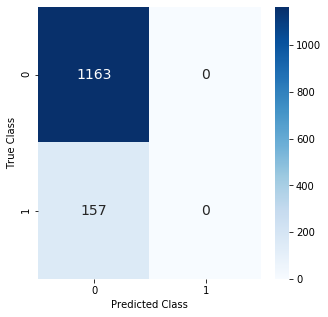

In [27]:
print(classification_report(Y_test , final_prediction))
results = confusion_matrix(Y_test , final_prediction)

%matplotlib inline
plt.figure(figsize = (5,5))
ax = sns.heatmap(results, cmap="Blues", annot=True,annot_kws={"size": 14},fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [22]:
f1_score(Y_test.values, final_prediction, average='macro')  

0.468385018123238

In [0]:
def print_stuff(idx):
  global y_test_pred # probabilities
  global X_test
  global y_test #original class
  global y_test_predict_cat #predicted class
  # preprocessed_tweet
  print('preprocessed tweet')
  print(X_test.iloc[idx,1])
  # computed prob
  print('computed prob: ',y_test_pred[idx], 'class predicted: ',y_test_predict_cat[idx])
  print('original class: ',y_test[idx])

In [0]:
def prRed(skk): print("\033[91m {}\033[00m" .format(skk)) 
def prGreen(skk): print("\033[92m {}\033[00m" .format(skk)) 

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict_cat)

In [36]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

157 misclassifications


Red: original not offensive (0), classified as offensive (1) <br>
Green: original offensive (1), classified as not offensive (0)

In [43]:
limit = 10
counts = [0] *2
for index in misclassified[0]:
  if limit in counts:
    break
  #original not offensive (0), classified as offensive (1) 
  if y_test[index] == 0 and y_test_predict_cat[index] == 1:
    prRed(X_test.iloc[index,0])
    print_stuff(index)
    counts[0] += 1
  #original offensive (1), classified as not offensive (0)
  elif y_test[index] == 1 and y_test_predict_cat[index] == 0:
    prGreen(X_test.iloc[index,0])
    print_stuff(index)
    counts[1] += 1

 @USER I love that feeling that u get from going from Blues to purples. The discovery of new sexy loot!
preprocessed tweet
i love feel u get go blue purple discovery new sexy loot
computed prob:  [0 0 0] class predicted:  0
original class:  1
 @USER IM SAVING THIS GOOD SHITTTT
preprocessed tweet
im save good shitttt
computed prob:  [0 0 0] class predicted:  0
original class:  1
 @USER @USER Funny how on top of things" you are trying to show you are when its white republicans in the path of the storm. An entire Island was just left to fend for its self for 13 days before help arrived.  Trump is a FAKE PRESIDENT"
preprocessed tweet
funny top things you try show you its white republicans path storm entire island leave fend its self 13 days help arrive trump fake president
computed prob:  [0 0 0] class predicted:  0
original class:  1
 @USER UK Govt non announcements are the only consistant and affordable policy under Labour or Conservatives for decades. Designed for a soundbite. No immedi

### without k fold

In [23]:
model = create_model(filter_kernels, dense_outputs, maxlen, vocab_size, nb_filter, cat_output)
model.fit( X_train_bow , Y_train_cat , class_weight = class_weight , batch_size=batch_size, epochs=nb_epoch, validation_split=0.3)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1020)              0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 1020, 69)          0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 1014, 256)         123904    
_________________________________________________________________
MaxPool1 (MaxPooling1D)      (None, 338, 256)          0         
_________________________________________________________________
Conv2 (Conv1D)               (None, 334, 256)          327936    
_________________________________________________________________
MaxPool2 (MaxPooling1D)      (None, 111, 256)          0         
_________________________________________________________________
Conv3 (Conv1D)               (None, 109, 256)          1968

### prediction and confusion matrix

In [0]:
y_test_predict = model.predict(X_test_bow)
y_test_predict_cat = y_test_predict.argmax(axis = 1)

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1163
           1       0.00      0.00      0.00       157

    accuracy                           0.88      1320
   macro avg       0.44      0.50      0.47      1320
weighted avg       0.78      0.88      0.83      1320



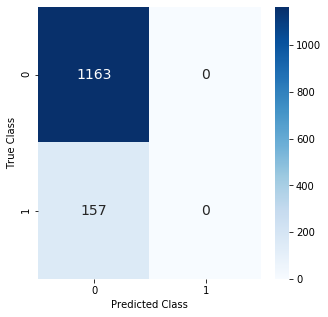

In [25]:
print(classification_report(Y_test , y_test_predict_cat))
results = confusion_matrix(Y_test , y_test_predict_cat)

%matplotlib inline
plt.figure(figsize = (5,5))
ax = sns.heatmap(results, cmap="Blues", annot=True,annot_kws={"size": 14},fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [28]:
f1_score(Y_test.values, final_prediction, average='macro')  

0.468385018123238

#### Misclassified examples

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict_cat)

In [30]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

157 misclassifications


Red: original not offensive (0), classified as offensive (1) <br>
Green: original offensive (1), classified as not offensive (0)

In [0]:
limit = 10
counts = [0] *2
for index in misclassified[0]:
  if limit in counts:
    break
  #original not offensive (0), classified as offensive (1) 
  if y_test[index] == 0 and y_test_predict_cat[index] == 1:
    prRed(X_test.iloc[index,0])
    print_stuff(index)
    counts[0] += 1
  #original offensive (1), classified as not offensive (0)
  elif y_test[index] == 1 and y_test_predict_cat[index] == 0:
    prGreen(X_test.iloc[index,0])
    print_stuff(index)
    counts[1] += 1

 @USER We are “Casually fucked”
 @USER I love that feeling that u get from going from Blues to purples. The discovery of new sexy loot!
 @USER the owner of my culo
 @USER IM SAVING THIS GOOD SHITTTT
 @USER @USER Because he is a traitor
 @USER @USER Funny how on top of things" you are trying to show you are when its white republicans in the path of the storm. An entire Island was just left to fend for its self for 13 days before help arrived.  Trump is a FAKE PRESIDENT"
 @USER fucking s league football HAHAHAH URL
 @USER UK Govt non announcements are the only consistant and affordable policy under Labour or Conservatives for decades. Designed for a soundbite. No immediate resource required. Never likely to ever be implemented. Its propoganda but sadly it has its desired effect.
 @USER How he is still batting
 @USER Do they drug test in tennis? Shes on some serious hormones or testosterone
 @USER can you pls get rid of holly he is so uneducated of sports. Wheb you have sportscasters who 

In [0]:
!sudo pip install PyYAML

In [0]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open(root_path + "/CNN/model_B.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights(root_path + "/CNN/model_B.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
root_path

'/content/gdrive/My Drive/IRE_Major_Project/'

In [0]:
!ls '/content/gdrive/My Drive/IRE_Major_Project/CNN'

CNN_A.ipynb  CNN_B.ipynb  CNN_C.ipynb  model_B.h5  model_B.yaml
